In [1]:
import h5py
import xarray as xr
import numpy as np
from astropy import units as u
from specutils import Spectrum
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.units import Quantity

In [8]:
import astropy.units as u
from astropy.modeling.polynomial import Chebyshev1D
from astropy.modeling.fitting import TRFLSQFitter

from specutils.fitting import fit_lines
from specutils.manipulation.smoothing import median_smooth
from specutils.spectra import SpectralRegion


__all__ = ['fit_continuum', 'fit_generic_continuum']

def fit_generic_continuum(spectrum, median_window=3, model=Chebyshev1D(6),
                          fitter=TRFLSQFitter(),
                          exclude_regions=None, weights=None):
    """
    Basic fitting of the continuum of an input spectrum. The input
    spectrum is smoothed using a median filter to remove the spikes.

    Parameters
    ----------
    spectrum : Spectrum
        The spectrum object overwhich the equivalent width will be calculated.
    model : list of `~astropy.modeling.Model`
        The list of models that contain the initial guess.
    median_window : float
        The width of the median smoothing kernel used to filter the data before
        fitting the continuum. See the ``kernel_size`` parameter of
        `~scipy.signal.medfilt` for more information.
    fitter : `~astropy.fitting._FitterMeta`
        The astropy fitter to use for fitting the model.
        Default: `~astropy.modeling.fitting.TRFLSQFitter`
    exclude_regions : list of 2-tuples
        List of regions to exclude in the fitting. Passed through
        to the fitmodels routine.
    weights : list  (NOT IMPLEMENTED YET)
        List of weights to define importance of fitting regions.

    Returns
    -------
    continuum_model
        Fitted continuum as a model of whatever class ``model`` provides.

    Notes
    -----
       * Could add functionality to set the bounds in
         ``model`` if they are not set.
       * The models in the list of ``model`` are added together and passed as a
         compound model to the `~astropy.modeling.fitting.Fitter` class instance.

    """
    # Simple median smooth to remove spikes and peaks
    spectrum_smoothed = median_smooth(spectrum, median_window)

    return fit_continuum(spectrum_smoothed, model=model, fitter=fitter,
                         exclude_regions=exclude_regions, weights=weights)



def fit_continuum(spectrum, model=Chebyshev1D(3), fitter=TRFLSQFitter(),
                  exclude_regions=None, exclude_region_upper_bounds=False,
                  window=None, weights=None):
    """
    Entry point for fitting using the `~astropy.modeling.fitting`
    machinery.

    Parameters
    ----------
    spectrum : Spectrum
        The spectrum object overwhich the equivalent width will be calculated.
    model: list of `~astropy.modeling.Model`
        The list of models that contain the initial guess.
    fitter : `~astropy.fitting._FitterMeta`
        The astropy fitter to use for fitting the model.
        Default: `~astropy.modeling.fitting.TRFLSQFitter`
    exclude_regions : list of 2-tuples
        List of regions to exclude in the fitting. Passed through
        to the fitmodels routine.
    exclude_region_upper_bounds : bool, optional
        Set to True to override the default pythonic slicing on the excluded regions (inclusive
        lower bound, exclusive upper bound) and remove spectral values less than or equal to
        the upper bound of the region rather than strictly less than the upper bound. Passed
        through to the fitmodels routine.
    window : tuple of wavelengths
        Start and end wavelengths used for fitting.
    weights : list  (NOT IMPLEMENTED YET)
        List of weights to define importance of fitting regions.

    Returns
    -------
    models : list of `~astropy.modeling.Model`
        The list of models that contain the fitted model parameters.
    """
    if weights is not None:
        raise NotImplementedError("Weights support is not yet implemented.")

    w = window
    if type(w) in [list, tuple] and all([_is_valid_sequence(x) for x in w]):
        w = SpectralRegion(w)

    # Fit the flux to the model
    continuum_spectrum = fit_lines(spectrum, model, fitter, exclude_regions,
                                   exclude_region_upper_bounds, weights, w)

    return continuum_spectrum




# Checks for sequences of of 2-tuples with Quantities
def _is_valid_sequence(value):
    if type(value) in [list, tuple]:
        return len(value) == 2 and \
               isinstance(value[0], u.Quantity) and \
               isinstance(value[1], u.Quantity)

    return False

In [9]:
def correlation(spec1, spec2):
    """
    Performs cross-correlation of two spectra and normalizes the output.
    """
    # Ensure the spectra have the same length for correlation
    min_len = min(len(spec1.flux), len(spec2.flux))
    flux1 = spec1.flux.value[:min_len]
    flux2 = spec2.flux.value[:min_len]

    # Perform cross-correlation
    corr = np.correlate(flux1, flux2, mode='full')
    lags = np.arange(-min_len + 1, min_len)
    
    # Calculate the normalization factor
    # This is the product of the L2 norms (magnitudes) of the two arrays
    norm_factor = np.sqrt(np.sum(flux1**2) * np.sum(flux2**2))
    
    # Normalize the correlation array
    normalized_corr = corr / norm_factor
    
    return normalized_corr, lags

def polynomial_degree_n(x, *coefficients):
    """A helper function to create a polynomial of a given degree."""
    return sum(coefficients[i] * x**i for i in range(len(coefficients)))

def calculate_bic(ssr, N, k):
    """Calculates the Bayesian Information Criterion (BIC)."""
    if N == 0:
        return np.inf
    return N * np.log(ssr / N) + k * np.log(N)

def bic_continuum_fit(spectrum, max_order=5, exclusion_ranges=None):
    """
    Fits a continuum to a spectrum by selecting the best polynomial order
    based on BIC.

    Parameters:
    - spectrum: A Spectrum1D object containing the data.
    - max_order: The maximum polynomial order to test.
    - exclusion_ranges: A list of tuples, e.g., [(start1, end1), (start2, end2)],
                        specifying wavelength ranges to exclude from the fit.

    Returns:
    - A Spectrum1D object representing the best-fit continuum.
    """
    wavelength = spectrum.spectral_axis
    flux = spectrum.flux
    
    if exclusion_ranges:
        mask = np.ones(wavelength.shape, dtype=bool)
        for start, end in exclusion_ranges:
            mask &= ~((wavelength >= start) & (wavelength <= end))
    else:
        mask = np.ones(wavelength.shape, dtype=bool)

    x = wavelength[mask].value
    y = flux[mask].value
    
    print(f"DEBUG: Shape of masked x: {x.shape}, Shape of masked y: {y.shape}")

    best_bic = np.inf
    best_popt = None
    best_order = 0

    for n in range(max_order + 1):
        try:
            def current_poly(x, *coeffs):
                return polynomial_degree_n(x, *coeffs)

            popt, pcov = curve_fit(current_poly, x, y, p0=np.zeros(n + 1), maxfev=50000)
            
            y_fit = current_poly(x, *popt)
            residuals = y - y_fit
            ssr = np.sum(residuals ** 2)
            N = len(y)
            k = len(popt)
            bic = calculate_bic(ssr, N, k)

            if bic < best_bic:
                best_bic = bic
                best_popt = popt
                best_order = n

        except RuntimeError as e:
            print(f"Fit for order {n} failed: {e}")
            continue

    if best_popt is not None:
        def best_poly(x, *coeffs):
            return polynomial_degree_n(x, *coeffs)
        
        continuum_flux = best_poly(wavelength.value, *best_popt) * flux.unit
        return Spectrum(spectral_axis=wavelength, flux=continuum_flux)
    else:
        # Return a flat continuum with units if all fits fail
        continuum_flux = np.full_like(wavelength.value, np.nan) * flux.unit
        return Spectrum(spectral_axis=wavelength, flux=continuum_flux)
    

def find_best_line_depth(observed_spectrum, model_spectrum, sigma):
    """
    Finds the best-fit line depth scaling factor using a chi-squared test.
    Works whether inputs have units or are plain arrays.

    Returns best scale factor, minimum chi-squared, degrees of freedom, and reduced chi-squared.
    """
    # Convert observed and model flux to plain arrays
    obs_flux = observed_spectrum.flux.value if isinstance(observed_spectrum.flux, Quantity) else observed_spectrum.flux
    model_flux = model_spectrum.flux.value if isinstance(model_spectrum.flux, Quantity) else model_spectrum.flux
    
    # Convert sigma to plain array
    if isinstance(sigma, Quantity):
        sigma_val = sigma.value
    else:
        sigma_val = sigma

    scale_factors = np.linspace(0.5, 1.5, 100)
    chi_squared_values = []

    for A in scale_factors:
        scaled_model_flux = 1 - A * (1 - model_flux)
        chi_squared = np.sum(((obs_flux - scaled_model_flux) / sigma_val) ** 2)
        chi_squared_values.append(chi_squared)

    min_chi_squared = float(np.min(chi_squared_values))
    best_scale_factor = float(scale_factors[np.argmin(chi_squared_values)])

    # Degrees of freedom = number of data points - number of fitted parameters (here 1: scale factor)
    dof = len(obs_flux) - 1
    reduced_chi_squared = min_chi_squared / dof if dof > 0 else np.inf

    return best_scale_factor, min_chi_squared, dof, reduced_chi_squared

def plot_residuals(observed_spectrum, model_spectrum, scale_factor, sigma):
    """
    Plots residuals and their distribution for a given observed spectrum
    and scaled model spectrum.

    Parameters
    ----------
    observed_spectrum : Spectrum1D or similar
    model_spectrum : Spectrum1D or similar
    scale_factor : float
        Scaling factor applied to model line depth.
    sigma : array or Quantity
        Uncertainty array used in chi-squared calculation.
    """

    # Convert flux and sigma to plain arrays
    obs_flux = observed_spectrum.flux.value if hasattr(observed_spectrum.flux, 'value') else observed_spectrum.flux
    model_flux = model_spectrum.flux.value if hasattr(model_spectrum.flux, 'value') else model_spectrum.flux
    sigma_val = sigma.value if hasattr(sigma, 'value') else sigma

    # Apply scaling factor to model flux
    scaled_model_flux = 1 - scale_factor * (1 - model_flux)

    # Calculate residuals
    residuals = obs_flux - scaled_model_flux

    # Plot residuals vs wavelength
    plt.figure(figsize=(10, 5))
    plt.plot(observed_spectrum.spectral_axis, residuals, 'k-', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals: Observed - Scaled Model')
    plt.xlabel(f'Wavelength ({observed_spectrum.spectral_axis.unit})')
    plt.ylabel(f'Residual Flux ({observed_spectrum.flux.unit})')
    plt.grid(True)
    plt.show()

    # Plot histogram of residuals normalized by sigma
    normalized_residuals = residuals / sigma_val
    plt.figure(figsize=(8, 4))
    plt.hist(normalized_residuals, bins=50, alpha=0.7, color='blue', density=True)
    plt.title('Histogram of Residuals / Sigma')
    plt.xlabel('Residual / Sigma')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()



Processing spectrum pair 1 of 22...


  Debugging Normalization:
    Original flux: min=-0.71 Jy, max=3.31 Jy, mean=1.13 Jy
    Normalized flux: min=-14.00, max=13.19, mean=1.02
--------------------


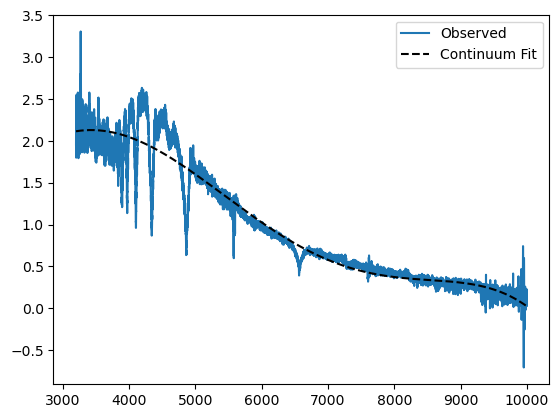

  Correlating with Model Grid A...


    The maximum number of function evaluations is exceeded. [astropy.modeling.fitting]


KeyboardInterrupt: 

In [10]:
#PRESTITCHED CC

from specutils.manipulation import LinearInterpolatedResampler
# Instantiate the resampler once
resampler = LinearInterpolatedResampler()

model_A = "Flux 3D Models/flux_model_3D_A.h5"
model_B = "Flux 3D Models/flux_model_3D_B.h5"

# Load data and define units
with h5py.File(model_A, 'r') as model_a_h5:
    model_a_flux = model_a_h5['flux'][()]
    model_a_wavelength = model_a_h5['wavelength'][()]
    model_a_gravity = model_a_h5['gravity'][()]
    model_a_temperature = model_a_h5['temperature'][()]

with h5py.File(model_B, 'r') as model_b_h5:
    model_b_flux = model_b_h5['flux'][()]
    model_b_wavelength = model_b_h5['wavelength'][()]
    model_b_gravity = model_b_h5['gravity'][()]
    model_b_temperature = model_b_h5['temperature'][()]

# Open the xarray dataset
stitched_spectra = xr.open_dataset("D:/Pavlicek, Emma/SDSS1411/SDSS1411_spectra.nc")
# Define the wavelength axis once since it is the same for all spectra
stitched_wavelength = u.Quantity(stitched_spectra['wavelength'].values, u.AA)

num_spectra = stitched_spectra.sizes['time'] # Get the number of spectra from the dataset dimensions

best_fits = []
# Iterate and stitch each pair of observed spectra
for i in range(num_spectra):
    try:
        print(f"\nProcessing spectrum pair {i+1} of {num_spectra}...")
        
        # Correctly extract the i-th spectrum with its units from the xarray dataset
        stitched_flux = u.Quantity(stitched_spectra['flux_calibrated'][i, :].values, u.Jy)
        # --- SCALE DATA TO ORDER UNITY ---
        scale = np.nanmedian(np.abs(stitched_spectra['flux_calibrated'][i, :].values))
        if not np.isfinite(scale) or scale == 0:
            scale = 1.0

        stitched_flux = stitched_flux / scale

        # Create a single Spectrum object from the current spectrum's data
        stitched_spectrum = Spectrum(spectral_axis=stitched_wavelength, flux=stitched_flux)
        
        # Normalize observed spectrum for cross-correlation
        stitched_continuum = fit_generic_continuum(stitched_spectrum)(stitched_spectrum.spectral_axis)
        stitched_spectrum_norm = stitched_spectrum / stitched_continuum
        
         # --- Debugging: Check Normalization ---
        print("  Debugging Normalization:")
        print(f"    Original flux: min={np.min(stitched_spectrum.flux):.2f}, max={np.max(stitched_spectrum.flux):.2f}, mean={np.mean(stitched_spectrum.flux):.2f}")
        print(f"    Normalized flux: min={np.min(stitched_spectrum_norm.flux):.2f}, max={np.max(stitched_spectrum_norm.flux):.2f}, mean={np.mean(stitched_spectrum_norm.flux):.2f}")
        print("-" * 20)
        plt.figure()
        plt.plot(stitched_spectrum.spectral_axis, stitched_spectrum.flux, label='Observed')
        # Corrected line: removed the .flux member from stitched_continuum
        plt.plot(stitched_spectrum.spectral_axis, stitched_continuum, label='Continuum Fit', color='black', linestyle='--')
        plt.legend()
        plt.show()

        # Cross-correlation with the stitched spectrum and each model grid
        # Cross-correlation with the stitched spectrum and each model grid
        best_correlation = -np.inf
        best_model_params = None
        best_denormalized_model = None

        # Correlate with Model Grid A
        print("  Correlating with Model Grid A...")
        for j, gravity in enumerate(model_a_gravity):
            for k, temperature in enumerate(model_a_temperature):
                model_flux = model_a_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_a_wavelength, u.Angstrom),
                                            flux=model_flux * u.Jy)
                
                model_spectrum_resampled = resampler(model_spectrum, stitched_spectrum.spectral_axis)
                model_spectrum_norm = model_spectrum_resampled / fit_generic_continuum(model_spectrum_resampled)(model_spectrum_resampled.spectral_axis)
                
                corr_array, lags = correlation(stitched_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                
                if max_correlation > best_correlation:
                    best_correlation = max_correlation
                    best_model_params = {'gravity': gravity, 'temperature': temperature, 'source': 'Model A'}
                    # Corrected line for Model A
                    stitched_continuum = fit_generic_continuum(stitched_spectrum,)(stitched_spectrum.spectral_axis)
                    best_denormalized_model = model_spectrum_norm.flux * stitched_continuum

        # Correlate with Model Grid B
        print("  Correlating with Model Grid B...")
        for j, gravity in enumerate(model_b_gravity):
            for k, temperature in enumerate(model_b_temperature):
                model_flux = model_b_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_b_wavelength, u.Angstrom),
                                            flux=model_flux * u.Jy)
                
                model_spectrum_resampled = resampler(model_spectrum, stitched_spectrum.spectral_axis)
                model_spectrum_norm = model_spectrum_resampled / fit_generic_continuum(model_spectrum_resampled)(model_spectrum_resampled.spectral_axis)
                
                corr_array, lags = correlation(stitched_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                
                if max_correlation > best_correlation:
                    best_correlation = max_correlation
                    best_model_params = {'gravity': gravity, 'temperature': temperature, 'source': 'Model B'}
                    # Corrected line for Model B
                    stitched_continuum = fit_generic_continuum(stitched_spectrum)(stitched_spectrum.spectral_axis)
                    best_denormalized_model = model_spectrum_norm.flux * stitched_continuum
                    
        # Store the best-fit parameters for the current spectrum
        if best_model_params:
            best_fits.append({
                'spectrum_id': i + 1,
                'best_correlation': best_correlation,
                'best_model_params': best_model_params,
                'observed_spectrum': stitched_spectrum,
                'side': 'stitched',
                'denormalized_model_flux': best_denormalized_model
            })
    except Exception as e:
        print(f"An error occurred while processing spectrum pair {i+1}: {e}")
        continue

# Print the final results for all spectra
print("\n--- Final Results for all Spectra ---")
if best_fits:
    for fit in best_fits:
        print(f"\nSpectrum ID: {fit['spectrum_id']}")
        print(f"  Best-fit Log(g) = {fit['best_model_params']['gravity']}")
        print(f"  Best-fit Temperature = {fit['best_model_params']['temperature']}")
        print(f"  Source Model Grid = {fit['best_model_params']['source']}")
        print(f"  Maximum Correlation Coefficient = {fit['best_correlation']:.4f}")
else:
    print("\nCould not find a best-fit model for any of the spectra.")

    # --- Plotting Code ---

print("\n--- Plotting Results ---")
for fit in best_fits:
    plt.figure(figsize=(12, 6))
    
    # Plot the original observed spectrum
    plt.plot(fit['observed_spectrum'].spectral_axis, fit['observed_spectrum'].flux, label=f'Observed Spectrum (ID: {fit["spectrum_id"]}, {fit["side"]} side)', color='blue', alpha=0.7)
    
    # Check if a denormalized model was successfully found before plotting
    if fit['denormalized_model_flux'] is not None:
        # Plot the denormalized best-fit model spectrum
        plt.plot(fit['observed_spectrum'].spectral_axis, fit['denormalized_model_flux'], label=f'Best-fit Model\n(Log(g)={fit["best_model_params"]["gravity"]}, T={fit["best_model_params"]["temperature"]})', color='red', linestyle='--')
    else:
        print(f"No best-fit model found for Spectrum ID: {fit['spectrum_id']} ({fit['side']} side).")
    
    # Add titles and labels
    plt.title(f'Spectrum ID: {fit["spectrum_id"]} ({fit["side"]} side) - Best-fit Model Comparison')
    plt.xlabel(f'Wavelength ({fit["observed_spectrum"].spectral_axis.unit})')
    plt.ylabel(f'Flux ({fit["observed_spectrum"].flux.unit})')
    plt.legend()
    plt.grid(True)
    plt.show()

if not best_fits:
    print("\nNo spectra were processed successfully to plot results.")

In [ ]:
#SIDE SPECIFIC CC
from specutils.manipulation import LinearInterpolatedResampler

num_spectra = blue_flux_data.shape[0]
best_fits = []

# Instantiate the resampler once
resampler = LinearInterpolatedResampler()

for i in range(num_spectra):
    try:
        print(f"\nProcessing spectrum pair {i+1} of {num_spectra}...")

        # Extract the i-th spectrum
        # For blue side
        blue_wave = blue_wavelength_data
        blue_flux = blue_flux_data[i, :]

        blue_mask = (blue_wave < 5500 * u.Angstrom) & (blue_wave > 3500 * u.Angstrom)
        blue_wave = blue_wave[blue_mask]
        blue_flux = blue_flux[blue_mask]

        blue_spectrum_i = Spectrum(spectral_axis=blue_wave, flux=blue_flux)

        # For red side
        red_wave = red_wavelength_data
        red_flux = red_flux_data[i, :]

        red_mask = red_wave > 6000 * u.Angstrom
        red_wave = red_wave[red_mask]
        red_flux = red_flux[red_mask]

        red_spectrum_i = Spectrum(spectral_axis=red_wave, flux=red_flux)

        # Normalize observed spectra for cross-correlation
        # Define the wavelength ranges to be excluded from the continuum fit
        # For the blue side, you might want to exclude H-beta (4861 Å) and H-gamma (4340 Å)
        blue_exclusion_ranges = [
            (3865 * u.Angstrom, 3930 * u.Angstrom),
            (4060 * u.Angstrom, 4140 * u.Angstrom),
            (4290 * u.Angstrom, 4407 * u.Angstrom),
            (4790 * u.Angstrom, 4950 * u.Angstrom),
        ]

        # Use the new function to find the best continuum fit
        blue_continuum = bic_continuum_fit(blue_spectrum_i, exclusion_ranges=blue_exclusion_ranges)
        # Normalize the spectrum as before
        blue_spectrum_norm = blue_spectrum_i / blue_continuum
        
        # --- Debugging: Check Normalization ---
        print("  Debugging Normalization:")
        print(f"    Original blue flux: min={np.min(blue_spectrum_i.flux):.2f}, max={np.max(blue_spectrum_i.flux):.2f}, mean={np.mean(blue_spectrum_i.flux):.2f}")
        print(f"    Normalized blue flux: min={np.min(blue_spectrum_norm.flux):.2f}, max={np.max(blue_spectrum_norm.flux):.2f}, mean={np.mean(blue_spectrum_norm.flux):.2f}")
        print("-" * 20)
        plt.figure()
        plt.plot(blue_spectrum_i.spectral_axis, blue_spectrum_i.flux, label='Observed')
        # Corrected line: use the .flux attribute
        plt.plot(blue_spectrum_i.spectral_axis, blue_continuum.flux, label='Continuum Fit', color='black', linestyle='--')
        plt.legend()
        plt.show()
        
        red_exclusion_ranges = [
            (6350 * u.Angstrom, 6700 * u.Angstrom),
            (6850 * u.Angstrom, 6930 * u.Angstrom),
            (7550 * u.Angstrom, 7800 * u.Angstrom)
        ]

        # Use the new function to find the best continuum fit
        red_continuum = bic_continuum_fit(red_spectrum_i, exclusion_ranges=red_exclusion_ranges)

        # Normalize the spectrum as before
        red_spectrum_norm = red_spectrum_i / red_continuum

        # --- Debugging: Check Normalization ---
        print("  Debugging Normalization:")
        print(f"    Original red flux: min={np.min(red_spectrum_i.flux):.2f}, max={np.max(red_spectrum_i.flux):.2f}, mean={np.mean(red_spectrum_i.flux):.2f}")
        print(f"    Normalized red flux: min={np.min(red_spectrum_norm.flux):.2f}, max={np.max(red_spectrum_norm.flux):.2f}, mean={np.mean(red_spectrum_norm.flux):.2f}")
        print("-" * 20)
        plt.figure()
        plt.plot(red_spectrum_i.spectral_axis, red_spectrum_i.flux, label='Observed')
        # Corrected line: use the .flux attribute
        plt.plot(red_spectrum_i.spectral_axis, red_continuum.flux, label='Continuum Fit', color='black', linestyle='--')
        plt.legend()
        plt.show()

        best_correlation_blue = -np.inf
        best_model_params_blue = None
        best_denormalized_blue_model = None

        # Correlate with Model Grid A (Blue side)
        print("  Correlating blue side with Model Grid A...")
        for j, gravity in enumerate(model_a_gravity):
            for k, temperature in enumerate(model_a_temperature):
                model_flux = model_a_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_a_wavelength, u.Angstrom),
                                           flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                # Resample model to match observed blue wavelength range
                model_spectrum_blue = resampler(model_spectrum, blue_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_blue / fit_generic_continuum(model_spectrum_blue)(model_spectrum_blue.spectral_axis)

                corr_array, lags = correlation(blue_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                
                if max_correlation > best_correlation_blue:
                    best_correlation_blue = max_correlation
                    best_model_params_blue = {'gravity': gravity, 'temperature': temperature, 'source': 'Model A'}
                    best_denormalized_blue_model = model_spectrum_norm.flux * blue_continuum.flux

        # Correlate with Model Grid B (Blue side)
        print("  Correlating blue side with Model Grid B...")
        for j, gravity in enumerate(model_b_gravity):
            for k, temperature in enumerate(model_b_temperature):
                model_flux = model_b_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_b_wavelength, u.Angstrom),
                                           flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                # Resample model to match observed blue wavelength range
                model_spectrum_blue = resampler(model_spectrum, blue_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_blue / fit_generic_continuum(model_spectrum_blue)(model_spectrum_blue.spectral_axis)

                corr_array, lags = correlation(blue_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                
                if max_correlation > best_correlation_blue:
                    best_correlation_blue = max_correlation
                    best_model_params_blue = {'gravity': gravity, 'temperature': temperature, 'source': 'Model B'}
                    best_denormalized_blue_model = model_spectrum_norm.flux * blue_continuum.flux

        # Store the blue-side results in a dictionary
        if best_model_params_blue is not None:
            blue_fit_result = {
                'spectrum_id': i + 1,
                'side': 'blue',
                'best_correlation': best_correlation_blue,
                'best_model_params': best_model_params_blue,
                'observed_spectrum': blue_spectrum_i,
                'denormalized_model_flux': best_denormalized_blue_model
            }
            best_fits.append(blue_fit_result)

        best_correlation_red = -np.inf
        best_model_params_red = None
        best_denormalized_red_model = None

        # Correlate with Model Grid A (Red side)
        print("  Correlating red side with Model Grid A...")
        for j, gravity in enumerate(model_a_gravity):
            for k, temperature in enumerate(model_a_temperature):
                model_flux = model_a_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_a_wavelength, u.Angstrom),
                                           flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                # Resample model to match observed red wavelength range
                model_spectrum_red = resampler(model_spectrum, red_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_red / fit_generic_continuum(model_spectrum_red)(model_spectrum_red.spectral_axis)

                corr_array, lags = correlation(red_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                
                if max_correlation > best_correlation_red:
                    best_correlation_red = max_correlation
                    best_model_params_red = {'gravity': gravity, 'temperature': temperature, 'source': 'Model A'}
                    best_denormalized_red_model = model_spectrum_norm.flux * red_continuum.flux

        # Correlate with Model Grid B (Red side)
        print("  Correlating red side with Model Grid B...")
        for j, gravity in enumerate(model_b_gravity):
            for k, temperature in enumerate(model_b_temperature):
                model_flux = model_b_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_b_wavelength, u.Angstrom),
                                           flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                # Resample model to match observed red wavelength range
                model_spectrum_red = resampler(model_spectrum, red_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_red / fit_generic_continuum(model_spectrum_red)(model_spectrum_red.spectral_axis)

                corr_array, lags = correlation(red_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                
                if max_correlation > best_correlation_red:
                    best_correlation_red = max_correlation
                    best_model_params_red = {'gravity': gravity, 'temperature': temperature, 'source': 'Model B'}
                    best_denormalized_red_model = model_spectrum_norm.flux * red_continuum.flux

        if best_model_params_red is not None:
            red_fit_result = {
                'spectrum_id': i + 1,
                'side': 'red',
                'best_correlation': best_correlation_red,
                'best_model_params': best_model_params_red,
                'observed_spectrum': red_spectrum_i,
                'denormalized_model_flux': best_denormalized_red_model
            }
            best_fits.append(red_fit_result)
    except Exception as e:
        print(f"An error occurred while processing spectrum pair {i+1}: {e}")
        continue

# --- Plotting Code ---

print("\n--- Plotting Results ---")
for fit in best_fits:
    plt.figure(figsize=(12, 6))
    
    # Plot the original observed spectrum
    plt.plot(fit['observed_spectrum'].spectral_axis, fit['observed_spectrum'].flux, label=f'Observed Spectrum (ID: {fit["spectrum_id"]}, {fit["side"]} side)', color='blue', alpha=0.7)
    
    # Check if a denormalized model was successfully found before plotting
    if fit['denormalized_model_flux'] is not None:
        # Plot the denormalized best-fit model spectrum
        plt.plot(fit['observed_spectrum'].spectral_axis, fit['denormalized_model_flux'], label=f'Best-fit Model\n(Log(g)={fit["best_model_params"]["gravity"]}, T={fit["best_model_params"]["temperature"]})', color='red', linestyle='--')
    else:
        print(f"No best-fit model found for Spectrum ID: {fit['spectrum_id']} ({fit['side']} side).")
    
    # Add titles and labels
    plt.title(f'Spectrum ID: {fit["spectrum_id"]} ({fit["side"]} side) - Best-fit Model Comparison')
    plt.xlabel(f'Wavelength ({fit["observed_spectrum"].spectral_axis.unit})')
    plt.ylabel(f'Flux ({fit["observed_spectrum"].flux.unit})')
    plt.legend()
    plt.grid(True)
    plt.show()

if not best_fits:
    print("\nNo spectra were processed successfully to plot results.")

In [ ]:
#MAKING DATASET
import xarray as xr
import pandas as pd

# Assume 'best_fits' is the list of dictionaries from your code
# If you don't have it, uncomment the following block to use a sample
"""
best_fits = [
    {
        'spectrum_id': 1,
        'best_correlation': 0.956,
        'best_model_params': {
            'gravity': 4.5,
            'temperature': 5700,
            'source': 'Model A'
        }
    },
    {
        'spectrum_id': 2,
        'best_correlation': 0.887,
        'best_model_params': {
            'gravity': 5.0,
            'temperature': 5800,
            'source': 'Model B'
        }
    },
    {
        'spectrum_id': 3,
        'best_correlation': 0.921,
        'best_model_params': {
            'gravity': 4.0,
            'temperature': 5650,
            'source': 'Model A'
        }
    }
]
"""

# Flatten the nested 'best_model_params' dictionary for easier conversion
flat_best_fits = []
for item in best_fits:
    flat_item = {
        'spectrum_id': item['spectrum_id'],
        'best_correlation': item['best_correlation'],
        **item['best_model_params']  # Unpack the nested dictionary
    }
    flat_best_fits.append(flat_item)

# Convert the flattened list of dictionaries to a pandas DataFrame
df_best_fits = pd.DataFrame(flat_best_fits)

# Convert the pandas DataFrame to an xarray Dataset
# Setting 'spectrum_id' as the coordinate
xarray_best_fits = xr.Dataset.from_dataframe(df_best_fits.set_index('spectrum_id'))

# Print the resulting xarray Dataset to inspect its structure
print(xarray_best_fits)

# You can save the xarray dataset to a file (e.g., a NetCDF file) for later use
# xarray_best_fits.to_netcdf('best_fits_xarray.nc')

In [ ]:
#SAVING DATASET
# Assuming 'xarray_best_fits' is the xarray Dataset you want to save
try:
    xarray_best_fits.to_netcdf('best_fits.nc')
    print("Successfully saved xarray Dataset to 'best_fits.nc'")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

Plotting specific model: Log(g)=800, T=13000 from Model Grid B


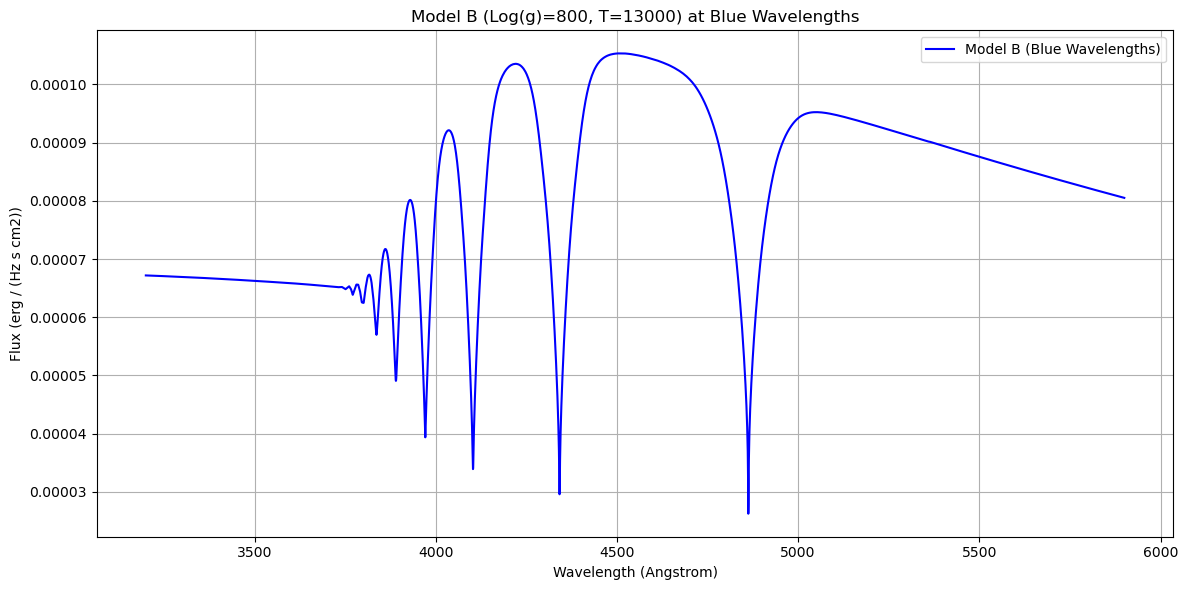

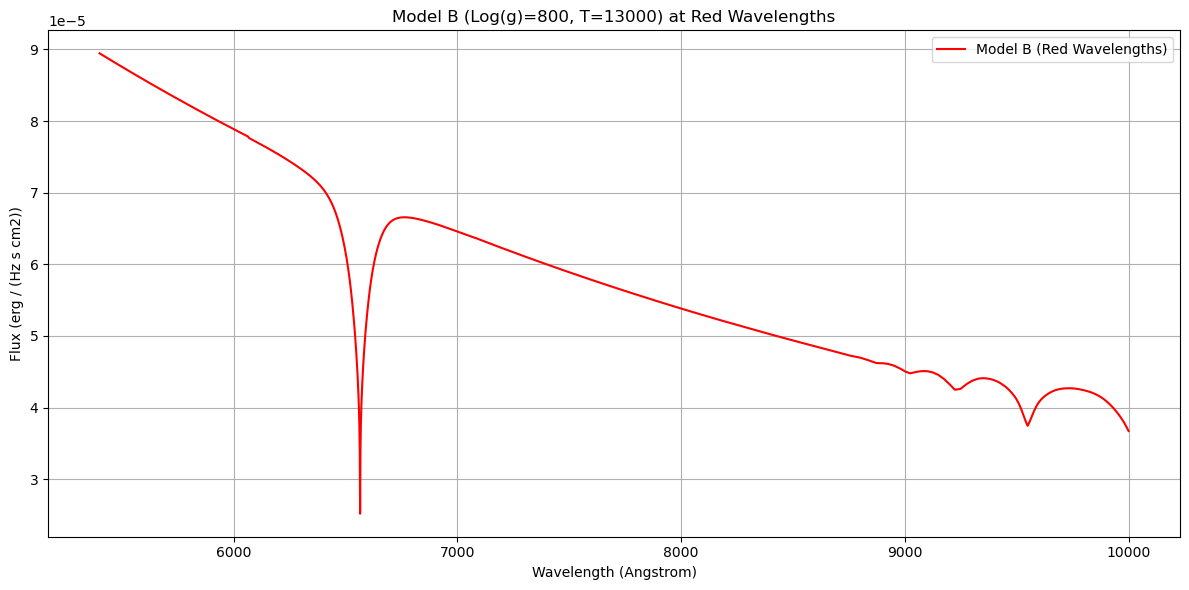


Finished plotting specific model spectra.


In [ ]:
#MODEL PLOTTING
# Define the specific model parameters you want to plot
desired_gravity = 800
desired_temperature = 13000

print(f"Plotting specific model: Log(g)={desired_gravity}, T={desired_temperature} from Model Grid B")

# Find the specific model in Model Grid B
try:
    j_b = np.where(model_b_gravity == desired_gravity)[0][0]
    k_b = np.where(model_b_temperature == desired_temperature)[0][0]
    model_flux_b_original = model_b_flux[j_b, :, k_b]
    model_spectrum_b_original = Spectrum(spectral_axis=u.Quantity(model_b_wavelength, u.Angstrom),
                                         flux=model_flux_b_original * u.erg / (u.cm**2 * u.s * u.Hz))
    
    # --- Plotting the Model at Blue Wavelengths ---
    plt.figure(figsize=(12, 6))
    
    # Resample the model to the observed blue wavelength range
    model_spectrum_blue_resampled = resampler(model_spectrum_b_original, 
                                              u.Quantity(blue_wavelength_data, u.Angstrom))
    
    plt.plot(model_spectrum_blue_resampled.spectral_axis, model_spectrum_blue_resampled.flux, 
             color='blue', linestyle='-', label=f'Model B (Blue Wavelengths)')
    
    plt.title(f'Model B (Log(g)={desired_gravity}, T={desired_temperature}) at Blue Wavelengths')
    plt.xlabel(f'Wavelength ({model_spectrum_blue_resampled.spectral_axis.unit})')
    plt.ylabel(f'Flux ({model_spectrum_blue_resampled.flux.unit})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plotting the Model at Red Wavelengths ---
    plt.figure(figsize=(12, 6))
    
    # Resample the model to the observed red wavelength range
    model_spectrum_red_resampled = resampler(model_spectrum_b_original, 
                                             u.Quantity(red_wavelength_data, u.Angstrom))
    
    plt.plot(model_spectrum_red_resampled.spectral_axis, model_spectrum_red_resampled.flux, 
             color='red', linestyle='-', label=f'Model B (Red Wavelengths)')
    
    plt.title(f'Model B (Log(g)={desired_gravity}, T={desired_temperature}) at Red Wavelengths')
    plt.xlabel(f'Wavelength ({model_spectrum_red_resampled.spectral_axis.unit})')
    plt.ylabel(f'Flux ({model_spectrum_red_resampled.flux.unit})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

except IndexError:
    print(f"  Model B with Log(g)={desired_gravity}, T={desired_temperature} not found in Model Grid B.")

print("\nFinished plotting specific model spectra.")


In [ ]:
#DATASET MAKER
import netCDF4 as nc

# Replace 'best_fits.nc' with the path to your file
file_path = 'best_fits.nc'
dataset = nc.Dataset(file_path, 'r')

# Print the variables available in the file
print(dataset.variables)

# To access a specific variable, for example, 'best_correlation'
best_correlation_data = dataset.variables['best_correlation'][:]
print(best_correlation_data)

# Don't forget to close the file
dataset.close()

In [ ]:
#CC HEAT MAP
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Open the NetCDF file
file_path = 'best_fits.nc'
dataset = nc.Dataset(file_path, 'r')

# Read the variables
temperatures = dataset.variables['temperature'][:]
gravities = dataset.variables['gravity'][:]
correlations = dataset.variables['best_correlation'][:]

dataset.close()

# Create a grid for the heat map
grid_temp = np.linspace(temperatures.min(), temperatures.max(), 100)
grid_grav = np.linspace(gravities.min(), gravities.max(), 100)
grid_temperatures, grid_gravities = np.meshgrid(grid_temp, grid_grav)

# Interpolate the correlation data onto the new grid
interpolated_correlations = griddata(
    (temperatures, gravities),
    correlations,
    (grid_temperatures, grid_gravities),
    method='cubic'
)

# Create the heat map
plt.figure(figsize=(10, 8))
plt.pcolormesh(grid_temperatures, grid_gravities, interpolated_correlations, shading='auto', cmap='viridis')
plt.colorbar(label='Best Correlation')
plt.xlabel('Temperature (K)')
plt.ylabel(r'log(g)')
plt.title('Heat Map of Best Correlation vs. Temperature and Gravity')
plt.savefig('correlation_heatmap.png')


Processing spectrum pair 2 of 22...
DEBUG: Shape of masked x: (3034,), Shape of masked y: (3034,)
DEBUG: Shape of masked x: (3906,), Shape of masked y: (3906,)
Correlating blue side with Model Grid A...


Correlating blue side with Model Grid B...


Blue Side: Best-fit line depth scaling factor = 1.005, Min chi-squared = 0.05, DOF = 3845, Reduced chi-squared = 0.000


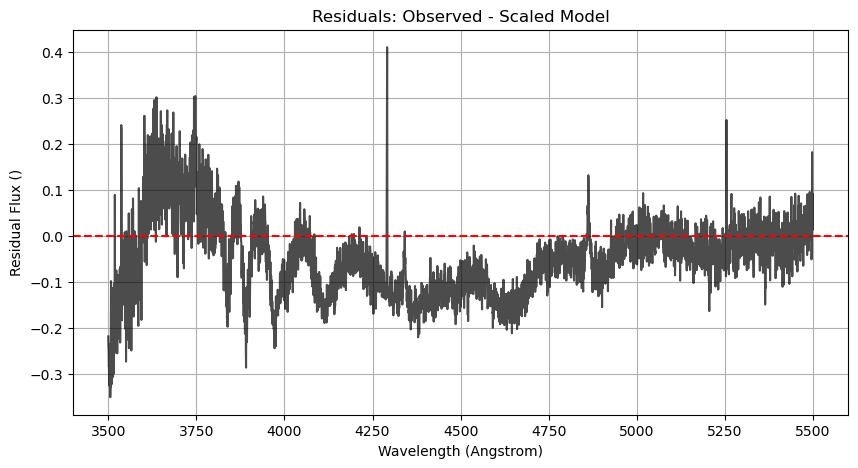

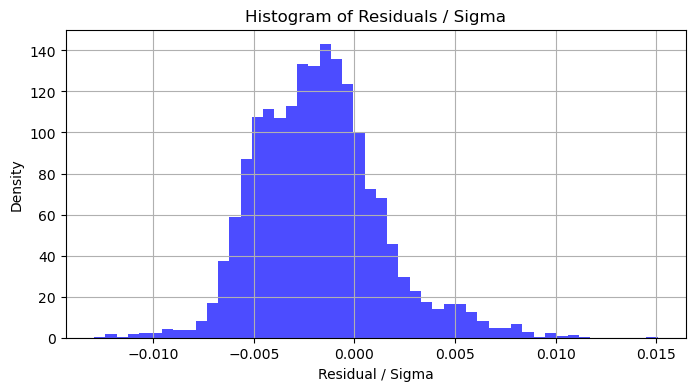

Correlating red side with Model Grid A...


Correlating red side with Model Grid B...


Red Side: Best-fit line depth scaling factor = 1.106, Min chi-squared = 0.22, DOF = 4705, Reduced chi-squared = 0.000


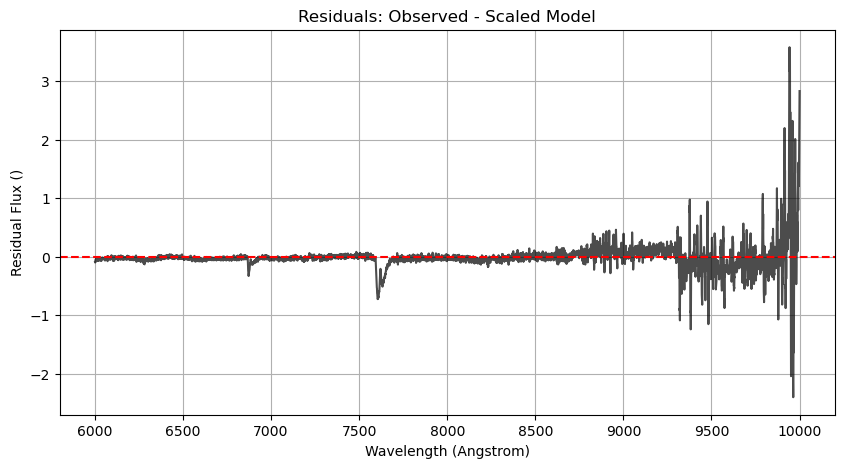

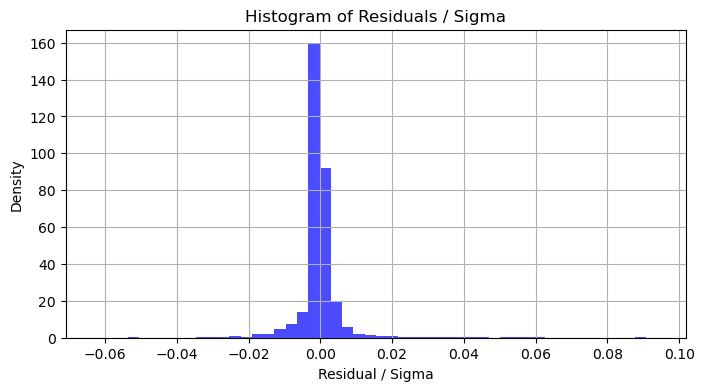


--- Plotting Results ---


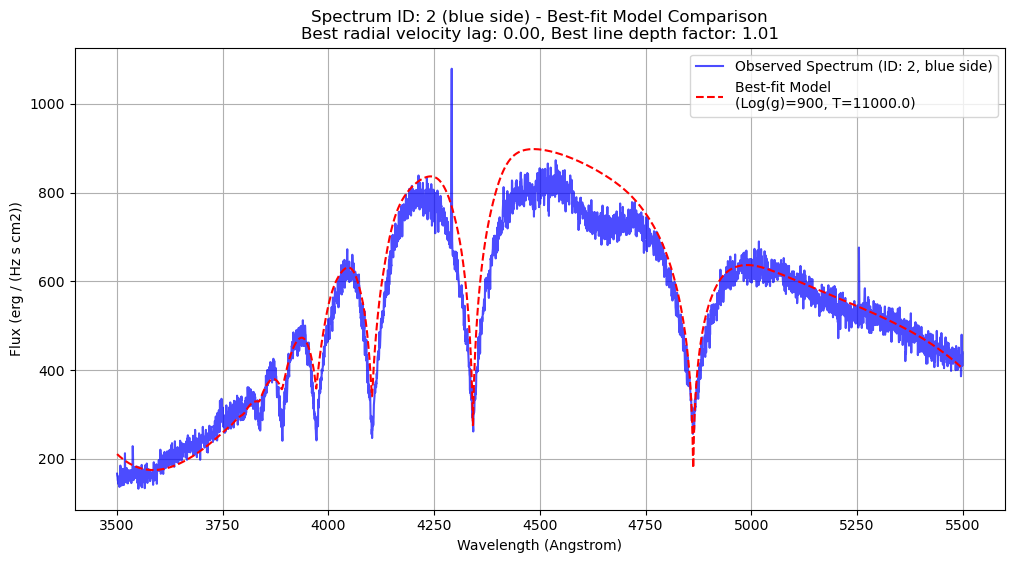

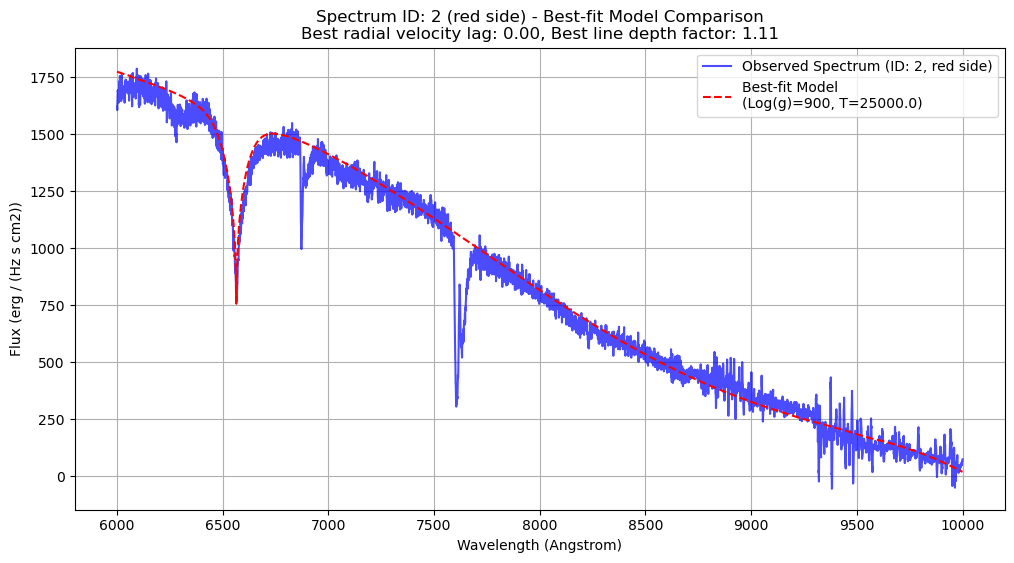

In [ ]:
#USING CHI TEST

num_spectra = blue_flux_data.shape[0]
best_fits = []
resampler = LinearInterpolatedResampler()

for i in range(1, 2):
    try:
        print(f"\nProcessing spectrum pair {i+1} of {num_spectra}...")
        # Initialize variables upfront to avoid undefined errors
        best_correlation_blue = -np.inf
        best_model_params_blue = None
        best_model_blue = None
        best_lag_blue = None

        best_correlation_red = -np.inf
        best_model_params_red = None
        best_model_red = None
        best_lag_red = None

        # Extract the i-th spectrum (blue side)
        blue_wave = blue_wavelength_data
        blue_flux = blue_flux_data[i, :]
        blue_mask = (blue_wave < 5500 * u.Angstrom) & (blue_wave > 3500 * u.Angstrom)
        blue_wave = blue_wave[blue_mask]
        blue_flux = blue_flux[blue_mask]
        blue_spectrum_i = Spectrum(spectral_axis=blue_wave, flux=blue_flux)

        # Normalize observed blue spectrum
        blue_exclusion_ranges = [
            (3865 * u.Angstrom, 3930 * u.Angstrom),
            (4060 * u.Angstrom, 4140 * u.Angstrom),
            (4290 * u.Angstrom, 4407 * u.Angstrom),
            (4790 * u.Angstrom, 4950 * u.Angstrom),
        ]
        blue_continuum = bic_continuum_fit(blue_spectrum_i, exclusion_ranges=blue_exclusion_ranges)
        blue_spectrum_norm = blue_spectrum_i / blue_continuum
        
        # Repeat for red side
        red_wave = red_wavelength_data
        red_flux = red_flux_data[i, :]
        red_mask = red_wave > 6000 * u.Angstrom
        red_wave = red_wave[red_mask]
        red_flux = red_flux[red_mask]
        red_spectrum_i = Spectrum(spectral_axis=red_wave, flux=red_flux)
        
        red_exclusion_ranges = [
            (6350 * u.Angstrom, 6700 * u.Angstrom),
            (6850 * u.Angstrom, 6930 * u.Angstrom),
            (7550 * u.Angstrom, 7800 * u.Angstrom)
        ]
        red_continuum = bic_continuum_fit(red_spectrum_i, exclusion_ranges=red_exclusion_ranges)
        red_spectrum_norm = red_spectrum_i / red_continuum

        # -----------------------------------------------------------
        # Step 1: Cross-correlation for best T, log(g), and velocity
        # -----------------------------------------------------------

        # Correlate with Model Grid A (Blue side)
        print("Correlating blue side with Model Grid A...")
        for j, gravity in enumerate(model_a_gravity):
            for k, temperature in enumerate(model_a_temperature):
                model_flux = model_a_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_a_wavelength, u.Angstrom),
                                            flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                model_spectrum_blue = resampler(model_spectrum, blue_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_blue / fit_generic_continuum(model_spectrum_blue)(model_spectrum_blue.spectral_axis)

                corr_array, lags = correlation(blue_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                max_lag = lags[np.argmax(corr_array)]
                
                if max_correlation > best_correlation_blue:
                    best_correlation_blue = max_correlation
                    best_model_params_blue = {'gravity': gravity, 'temperature': temperature, 'source': 'Model A'}
                    best_model_blue = model_spectrum_norm
                    best_lag_blue = max_lag

        # Correlate with Model Grid B (Blue side)
        print("Correlating blue side with Model Grid B...")
        for j, gravity in enumerate(model_b_gravity):
            for k, temperature in enumerate(model_b_temperature):
                model_flux = model_b_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_b_wavelength, u.Angstrom),
                                            flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                model_spectrum_blue = resampler(model_spectrum, blue_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_blue / fit_generic_continuum(model_spectrum_blue)(model_spectrum_blue.spectral_axis)

                corr_array, lags = correlation(blue_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                max_lag = lags[np.argmax(corr_array)]
                
                if max_correlation > best_correlation_blue:
                    best_correlation_blue = max_correlation
                    best_model_params_blue = {'gravity': gravity, 'temperature': temperature, 'source': 'Model B'}
                    best_model_blue = model_spectrum_norm
                    best_lag_blue = max_lag

        # -----------------------------------------------------------
        # Step 2: Chi-squared test for best line depth
        # -----------------------------------------------------------
        if best_model_blue is not None:
            blue_sigma = np.full_like(blue_spectrum_i.flux, 0.05 * np.median(blue_spectrum_i.flux))

            best_scale_factor_blue, min_chi_sq_blue, dof_blue, red_chi_sq_blue = find_best_line_depth(blue_spectrum_norm, best_model_blue, blue_sigma)
            print(f"Blue Side: Best-fit line depth scaling factor = {best_scale_factor_blue:.3f}, Min chi-squared = {min_chi_sq_blue:.2f}, DOF = {dof_blue}, Reduced chi-squared = {red_chi_sq_blue:.3f}")
            plot_residuals(blue_spectrum_norm, best_model_blue, best_scale_factor_blue, blue_sigma)

            best_denormalized_blue_model_flux = (1 - best_scale_factor_blue * (1 - best_model_blue.flux)) * blue_continuum.flux

            _fit_result = {
                'spectrum_id': i + 1,
                'side': 'blue',
                'best_correlation': float(best_correlation_blue),
                'best_model_params': best_model_params_blue,
                'best_radial_velocity_lag': float(best_lag_blue) if not hasattr(best_lag_blue, 'value') else float(best_lag_blue.value),
                'best_line_depth_factor': float(best_scale_factor_blue),
                'min_chi_squared': float(min_chi_sq_blue),
                'observed_spectrum': blue_spectrum_i,
                'denormalized_model_flux': (
                    best_denormalized_blue_model_flux.value if hasattr(best_denormalized_blue_model_flux, 'unit')
                    else best_denormalized_blue_model_flux
                )
            }
            best_fits.append(_fit_result)  # <-- fixed variable name here

        # -----------------------------------------------------------
        # Repeat the process for the red side
        # -----------------------------------------------------------
        print("Correlating red side with Model Grid A...")
        for j, gravity in enumerate(model_a_gravity):
            for k, temperature in enumerate(model_a_temperature):
                model_flux = model_a_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_a_wavelength, u.Angstrom),
                                            flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                model_spectrum_red = resampler(model_spectrum, red_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_red / fit_generic_continuum(model_spectrum_red)(model_spectrum_red.spectral_axis)

                corr_array, lags = correlation(red_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                max_lag = lags[np.argmax(corr_array)]
                
                if max_correlation > best_correlation_red:
                    best_correlation_red = max_correlation
                    best_model_params_red = {'gravity': gravity, 'temperature': temperature, 'source': 'Model A'}
                    best_model_red = model_spectrum_norm
                    best_lag_red = max_lag

        # Correlate with Model Grid B (red side)
        print("Correlating red side with Model Grid B...")
        for j, gravity in enumerate(model_b_gravity):
            for k, temperature in enumerate(model_b_temperature):
                model_flux = model_b_flux[j, :, k]
                model_spectrum = Spectrum(spectral_axis=u.Quantity(model_b_wavelength, u.Angstrom),
                                            flux=model_flux * u.erg / (u.cm**2 * u.s * u.Hz))
                
                model_spectrum_red = resampler(model_spectrum, red_spectrum_i.spectral_axis)
                model_spectrum_norm = model_spectrum_red / fit_generic_continuum(model_spectrum_red)(model_spectrum_red.spectral_axis)

                corr_array, lags = correlation(red_spectrum_norm, model_spectrum_norm)
                max_correlation = np.max(corr_array)
                max_lag = lags[np.argmax(corr_array)]
                
                if max_correlation > best_correlation_red:
                    best_correlation_red = max_correlation
                    best_model_params_red = {'gravity': gravity, 'temperature': temperature, 'source': 'Model B'}
                    best_model_red = model_spectrum_norm
                    best_lag_red = max_lag

        if best_model_red is not None:
            red_sigma = np.full_like(red_spectrum_i.flux, 0.05 * np.median(red_spectrum_i.flux))

            best_scale_factor_red, min_chi_sq_red, dof_red, red_chi_sq_red = find_best_line_depth(red_spectrum_norm, best_model_red, red_sigma)
            print(f"Red Side: Best-fit line depth scaling factor = {best_scale_factor_red:.3f}, Min chi-squared = {min_chi_sq_red:.2f}, DOF = {dof_red}, Reduced chi-squared = {red_chi_sq_red:.3f}")
            plot_residuals(red_spectrum_norm, best_model_red, best_scale_factor_red, red_sigma)
            
            best_denormalized_red_model_flux = (1 - best_scale_factor_red * (1 - best_model_red.flux)) * red_continuum.flux

            red_fit_result = {
                'spectrum_id': i + 1,
                'side': 'red',
                'best_correlation': float(best_correlation_red),
                'best_model_params': best_model_params_red,
                'best_radial_velocity_lag': float(best_lag_red) if not hasattr(best_lag_red, 'value') else float(best_lag_red.value),
                'best_line_depth_factor': float(best_scale_factor_red),
                'min_chi_squared': float(min_chi_sq_red),
                'observed_spectrum': red_spectrum_i,
                'denormalized_model_flux': (
                    best_denormalized_red_model_flux.value if hasattr(best_denormalized_red_model_flux, 'unit')
                    else best_denormalized_red_model_flux
                )
            }
            best_fits.append(red_fit_result)

    except Exception as e:
        print(f"An error occurred while processing spectrum pair {i+1}: {e}")
        continue

# --- Plotting Code ---

print("\n--- Plotting Results ---")
for fit in best_fits:
    plt.figure(figsize=(12, 6))
    
    # Plot the original observed spectrum
    plt.plot(fit['observed_spectrum'].spectral_axis, fit['observed_spectrum'].flux, label=f'Observed Spectrum (ID: {fit["spectrum_id"]}, {fit["side"]} side)', color='blue', alpha=0.7)
    
    # Check if a denormalized model was successfully found before plotting
    if fit['denormalized_model_flux'] is not None:
        # Plot the denormalized best-fit model spectrum
        plt.plot(fit['observed_spectrum'].spectral_axis, fit['denormalized_model_flux'], label=f'Best-fit Model\n(Log(g)={fit["best_model_params"]["gravity"]}, T={fit["best_model_params"]["temperature"]})', color='red', linestyle='--')
    else:
        print(f"No best-fit model found for Spectrum ID: {fit['spectrum_id']} ({fit['side']} side).")
    
    # Add titles and labels
    plt.title(f'Spectrum ID: {fit["spectrum_id"]} ({fit["side"]} side) - Best-fit Model Comparison\n'
              f'Best radial velocity lag: {fit["best_radial_velocity_lag"]:.2f}, '
              f'Best line depth factor: {fit["best_line_depth_factor"]:.2f}')
    plt.xlabel(f'Wavelength ({fit["observed_spectrum"].spectral_axis.unit})')
    plt.ylabel(f'Flux ({fit["observed_spectrum"].flux.unit})')
    plt.legend()
    plt.grid(True)
    plt.show()

if not best_fits:
    print("\nNo spectra were processed successfully to plot results.")